In [1]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

import numpy as np

boston = load_boston()
X = boston.data
y = boston.target

# 13 个特征
print(X.shape)  # (506, 13)
# 看看里面有什么
print(dir(boston))
#
print(boston.feature_names)

(506, 13)
['DESCR', 'data', 'feature_names', 'target']
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [2]:
# 模型训练
# 1、分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=666)
# 2、使用线性回归

# normalize=True 会加快收敛的速度，无法提升算法的准确率
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
cv_score = model.score(X_test, y_test)
print("baseline:")
print("训练数据集得分:", train_score)
print("测试数据集得分:", cv_score)
# 对训练样本的评分都比较低，这是欠拟合
# 训练数据集得分: 0.7608034620871522
# 测试数据集得分: 0.6334467294899586

baseline:
训练数据集得分: 0.7608034620871523
测试数据集得分: 0.6334467294899672


In [3]:
# 从得分效果上看，拟合效果一般，下面进行模型优化
# 优化1：归一化

# 看看每一列的最高值和最低值
np.set_printoptions(suppress=True)
print(X.max(axis=0))
print(X.min(axis=0))

[ 88.9762 100.      27.74     1.       0.871    8.78   100.      12.1265
  24.     711.      22.     396.9     37.97  ]
[  0.00632   0.        0.46      0.        0.385     3.561     2.9
   1.1296    1.      187.       12.6       0.32      1.73   ]


In [4]:
# 直接在线性回归的参数里面增加 normalize=True

# 优化2：增加模型的复杂度，这里选择使用多项式特征

def polynomial_features(degree=1):  # 设置默认参数
    polynomial_features = PolynomialFeatures(degree=degree)
    linear_regression = LinearRegression(normalize=True)
    return Pipeline(
        [('polynomial_features', polynomial_features),
         ('linear_regression', linear_regression)]
    )


print("使用多项式回归（二阶）:")
model = polynomial_features(degree=2)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
cv_score = model.score(X_test, y_test)
# 回归问题使用"R^2"作为评判标准
r2 = r2_score(y_test, model.predict(X_test))
print("训练数据集得分:", train_score)
print("测试数据集得分:", cv_score)
print("r2:", r2)

print("使用多项式回归（三阶）:")
model = polynomial_features(degree=3)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
cv_score = model.score(X_test, y_test)
print("训练数据集得分:", train_score)
print("测试数据集得分:", cv_score)
print("明显是过拟合了。")

使用多项式回归（二阶）:
训练数据集得分: 0.9468497447257228
测试数据集得分: 0.7687939625914362
r2: 0.7687939625914362
使用多项式回归（三阶）:
训练数据集得分: 1.0
测试数据集得分: -205.24322554170686
明显是过拟合了。


In [5]:
# 画出学习曲线（下面的函数可以作为模板函数）

def plot_learning_curve(plt, estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdt

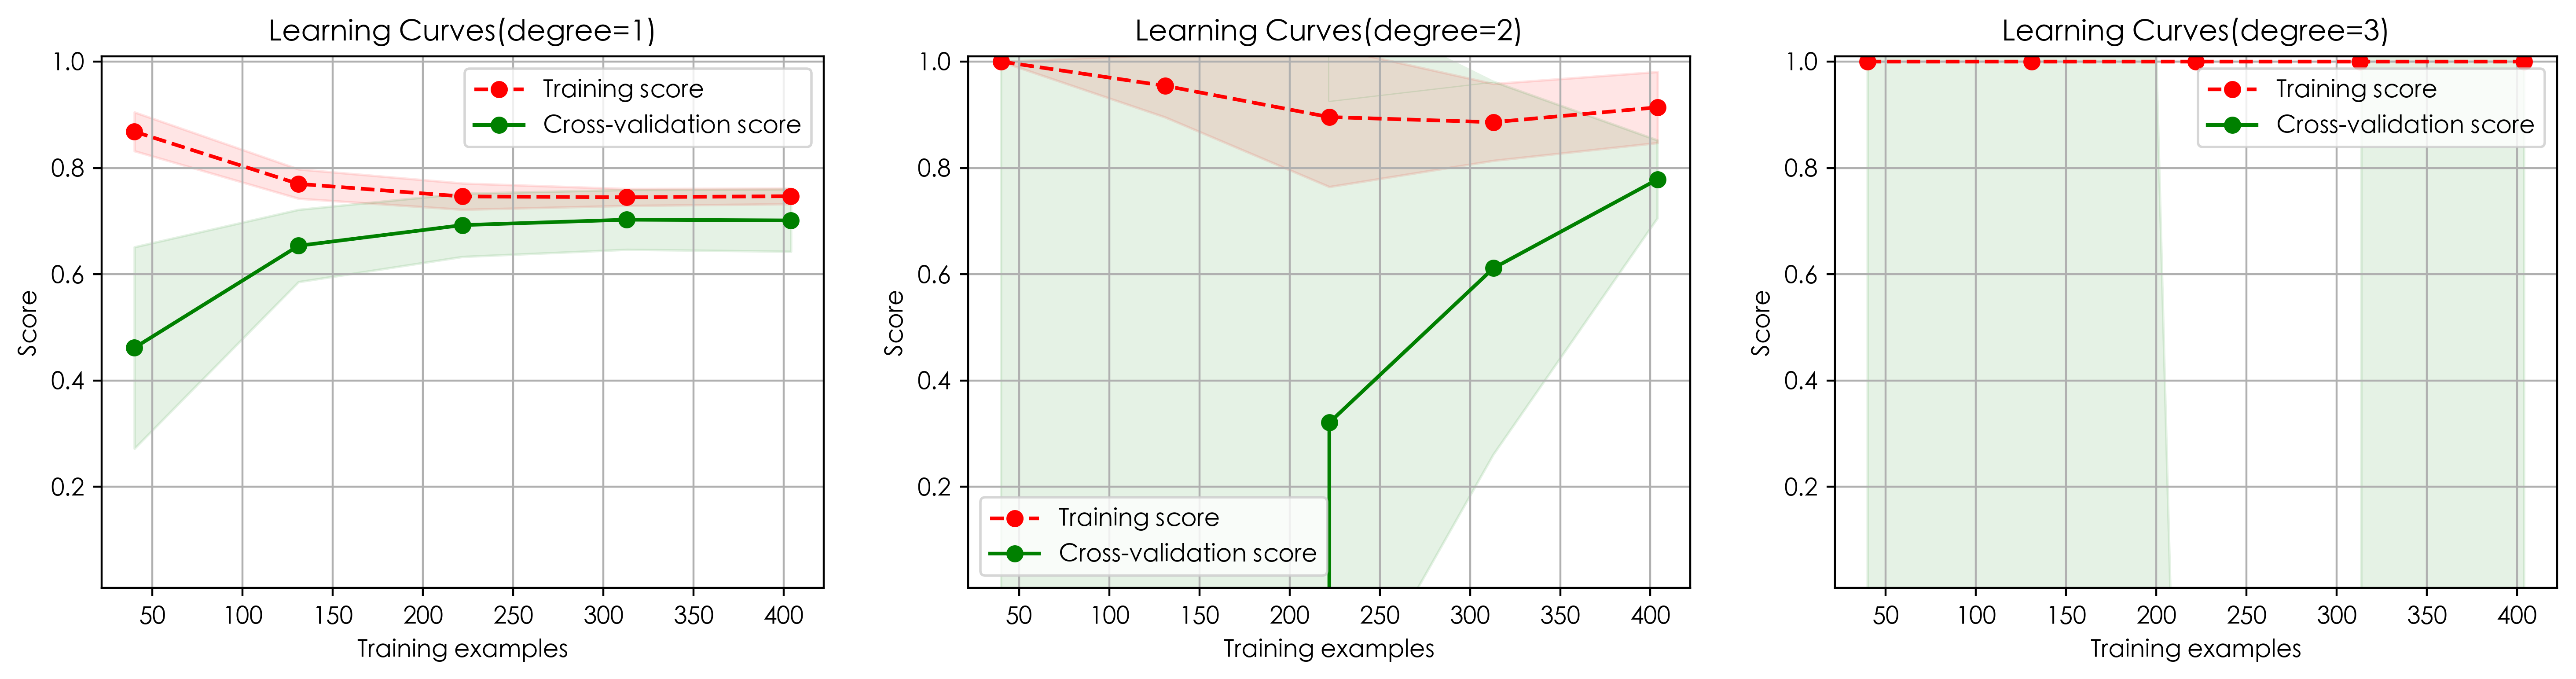

In [6]:
# 下面绘制学习曲线
cv = ShuffleSplit(n_splits=10,
                  test_size=.2,
                  random_state=666)
title = "Learning Curves(degree={0})"
degrees = [1, 2, 3]
plt.figure(figsize=(18, 4), dpi=200)

for index, degree in enumerate(degrees):
    plt.subplot(1, 3, 1 + index)
    plot_learning_curve(plt,
                        polynomial_features(degree=degree),
                        title.format(degree),
                        X,
                        y,
                        ylim=(0.01, 1.01),
                        cv=cv)
plt.show()